In [1]:
import os
import warnings
import torchvision.datasets as dset

from transformers import logging
from torch.utils.data import DataLoader

from encoder_models import *
from loss_functions import *
from utils_clip import *
from hooks import *

from tqdm import tqdm

logging.set_verbosity_error()
warnings.filterwarnings("ignore")

# Inits

In [2]:
config = load_config()

checkpoint_path = config['paths']['checkpoint']
vit_trans_name = 'google/vit-base-patch16-224'
bert_model_name = 'bert-base-uncased'
embed_dim = 128 ## make this dynamic

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print (f'Using: {device}')

coco_dataset_tst = dset.CocoCaptions(
    root=config['data']['test_root'],
    annFile=config['data']['test_ann']
)

test_dataset = CocoCaptionDataset(coco_dataset_tst, mode="test")

# instantiate
encoder_1 = Transformer_One(vit_trans_name, embed_dim, device=device)
encoder_2 = Transformer_Two(bert_model_name, embed_dim, device=device)
# load
encoder_1, encoder_2, opt_state_dct, _, loss_state_dct, epoch_load, tr_loss, vld_loss = load_model(checkpoint_path, encoder_1, encoder_2, device)
logit_sc = loss_state_dct['logit_scale'].exp() ## logit scale
# place
encoder_1.to(device)
encoder_2.to(device)

dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False, drop_last=False, num_workers=16)

Using: cuda:0
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


Loaded model from epoch 30 with training loss: 0.0732 and validation loss: 0.1717


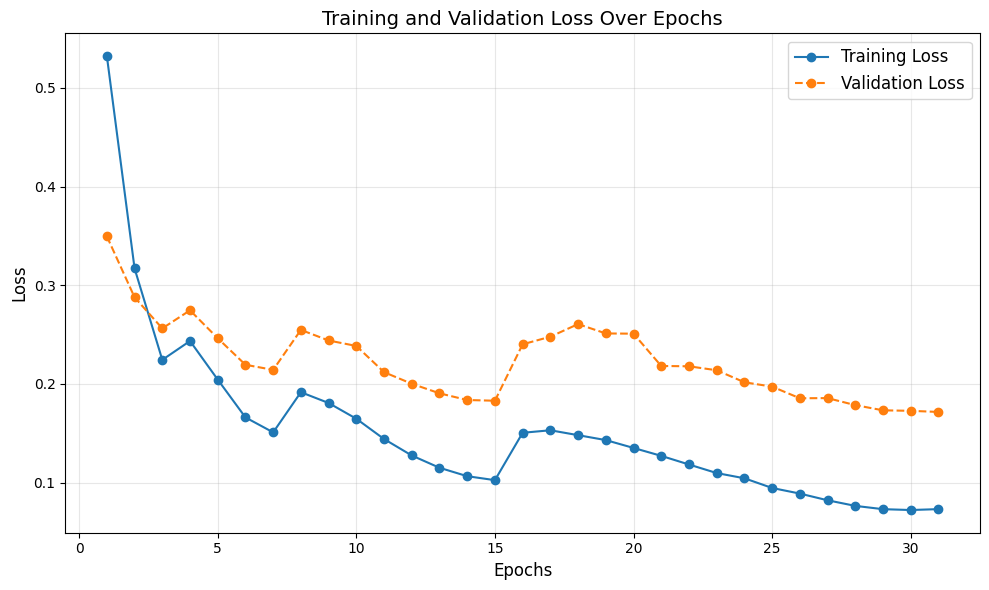

In [3]:
print(f"Loaded model from epoch {epoch_load} with training loss: {tr_loss[-1]:.4f} and validation loss: {vld_loss[-1]:.4f}")
plot_loss(tr_loss, vld_loss)

# Precompute Image embeddings

In [4]:
save_path = config['paths']['img_embedd']
pt_files = [f for f in os.listdir(save_path) if f.endswith('.pt')]

if not pt_files:
    precompute_img_emb(encoder_1, dataloader, save_path)

im_em = load_embeddings(save_path)
assert im_em.shape[0] == len(test_dataset), "Dimension mismatch!"
print (im_em.shape)

Extracting Image Embeddings...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [03:25<00:00,  5.01s/it]


test_set_img_5.pt
test_set_img_10.pt
test_set_img_15.pt
test_set_img_20.pt
test_set_img_25.pt
test_set_img_30.pt
test_set_img_35.pt
test_set_img_40.pt
test_set_img_42.pt
torch.Size([40670, 128])


# Enter query

Hook 0: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 1: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 2: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 3: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 4: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 5: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 6: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 7: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 8: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 9: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 10: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 11: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 0: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 1: Captured attention with shape torch.Size([1, 12, 197, 197])
Hook 2: Captured attention with shape torch.Si

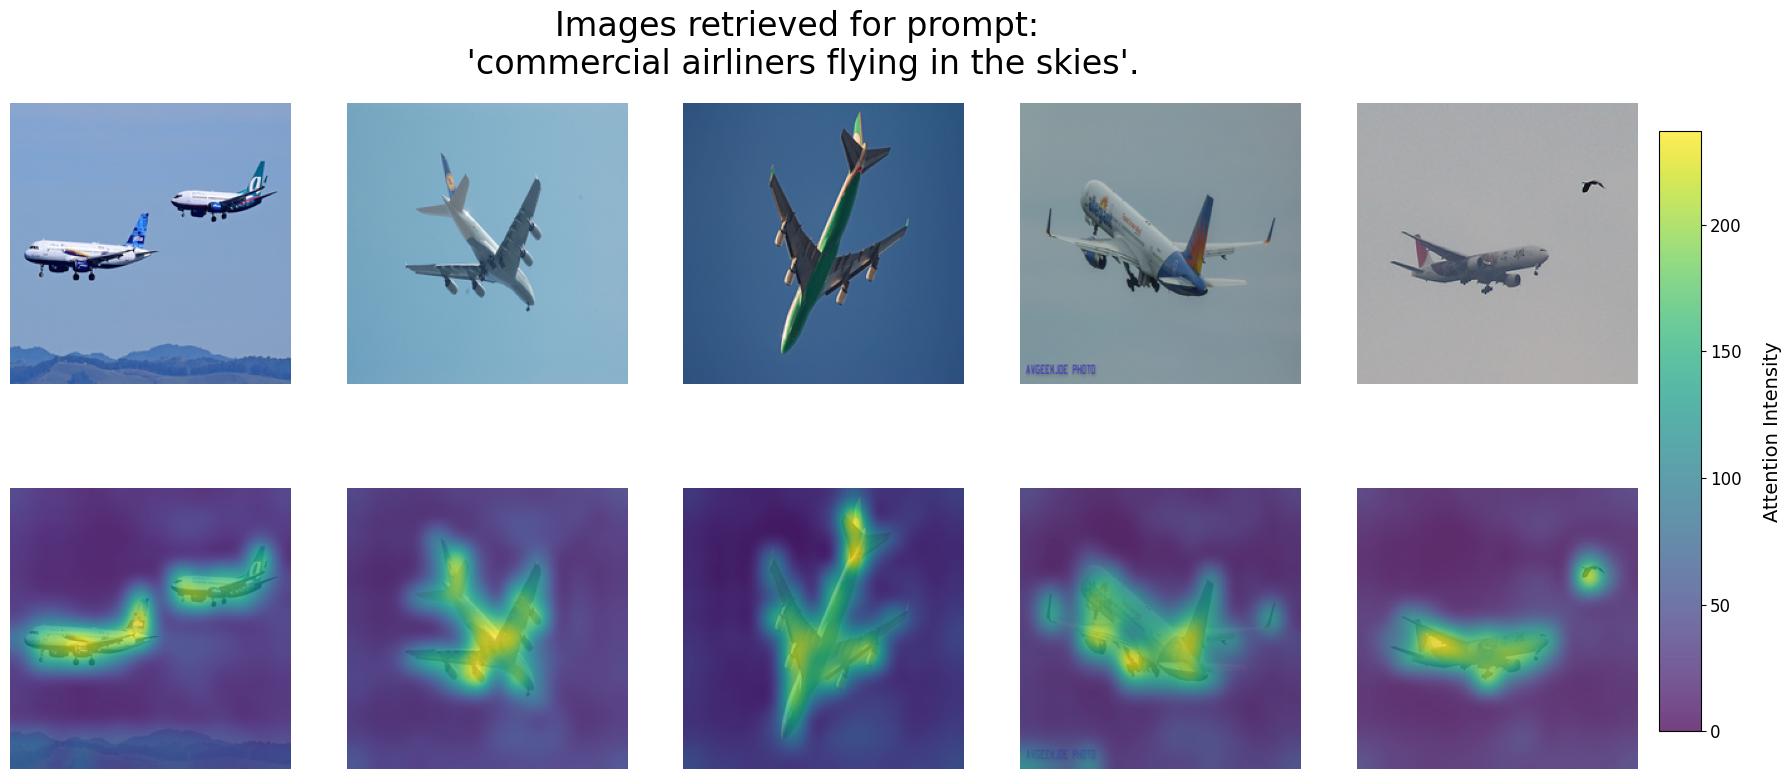

In [35]:
# prompt time!
query = 'commercial airliners flying in the skies'

query_embedding = compute_query_embedding(encoder_2, query, device)
top_idxs, sims = find_top_k_matches(im_em, query_embedding, logit_sc, k=5, device=device)

encoder_1.model.config.output_attentions=True
attention_layers = [encoder_1.model.encoder.layer[x].attention.attention for x in range(len(encoder_1.model.encoder.layer))] 
image_processor = ViTImageProcessor.from_pretrained(vit_trans_name)

attentions = []
images = []
# probe attention layers
with AttentionRecorder(attention_layers) as recorder:
    for i in range(len(top_idxs)):
        image, _ = coco_dataset_tst[top_idxs[i]]
        inputs = image_processor(images=image, return_tensors="pt")
        inputs = inputs["pixel_values"]
        with torch.no_grad():
            _ = encoder_1(inputs)
        valid_attentions = [attn for attn in recorder.saved_attentions.values() if attn is not None]
        attn_map_resized = attention_rollout(valid_attentions, image)
        # clear saved attentions for the next image
        attentions.append(attn_map_resized)
        images.append(image)
        recorder.saved_attentions = {i: None for i in recorder.saved_attentions}

q_title = f"Images retrieved for prompt:\n '{query}'."
plot_images_and_attentions(images, attentions, title=q_title)